# DRAFT - SKELETON ANIMATION

In [2]:
pwd

'C:\\Users\\Intel\\Documents\\@M2\\Idemia\\CODE'

In [3]:
cd ../human-action-recognition/data/nturgb+d_skeletons_cleaned/

C:\Users\Intel\Documents\@M2\Idemia\human-action-recognition\data\nturgb+d_skeletons_cleaned


In [4]:
cd ../nturgb+d_skeletons/

C:\Users\Intel\Documents\@M2\Idemia\human-action-recognition\data\nturgb+d_skeletons


In [5]:
pwd

'C:\\Users\\Intel\\Documents\\@M2\\Idemia\\human-action-recognition\\data\\nturgb+d_skeletons'

In [6]:
# %pip install imagemagick

In [7]:
%matplotlib notebook
# %pip install tqdm

In [8]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device : {}".format(device))

device : cpu


In [9]:
import os
import sys
import pickle
import argparse
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


ntu_skeleton_bone_pairs = tuple((i-1, j-1) for (i,j) in (
    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
    (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
    (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
    (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25),(25, 12)
))

bone_pairs = {
    'ntu/xview': ntu_skeleton_bone_pairs,
    'ntu/xsub': ntu_skeleton_bone_pairs,

    # NTU 120 uses the same skeleton structure as NTU 60
    'ntu120/xsub': ntu_skeleton_bone_pairs,
    'ntu120/xset': ntu_skeleton_bone_pairs,

    # NTU general
    'ntu': ntu_skeleton_bone_pairs,
}

bone_pairs

{'ntu/xview': ((0, 1),
  (1, 20),
  (2, 20),
  (3, 2),
  (4, 20),
  (5, 4),
  (6, 5),
  (7, 6),
  (8, 20),
  (9, 8),
  (10, 9),
  (11, 10),
  (12, 0),
  (13, 12),
  (14, 13),
  (15, 14),
  (16, 0),
  (17, 16),
  (18, 17),
  (19, 18),
  (21, 22),
  (20, 20),
  (22, 7),
  (23, 24),
  (24, 11)),
 'ntu/xsub': ((0, 1),
  (1, 20),
  (2, 20),
  (3, 2),
  (4, 20),
  (5, 4),
  (6, 5),
  (7, 6),
  (8, 20),
  (9, 8),
  (10, 9),
  (11, 10),
  (12, 0),
  (13, 12),
  (14, 13),
  (15, 14),
  (16, 0),
  (17, 16),
  (18, 17),
  (19, 18),
  (21, 22),
  (20, 20),
  (22, 7),
  (23, 24),
  (24, 11)),
 'ntu120/xsub': ((0, 1),
  (1, 20),
  (2, 20),
  (3, 2),
  (4, 20),
  (5, 4),
  (6, 5),
  (7, 6),
  (8, 20),
  (9, 8),
  (10, 9),
  (11, 10),
  (12, 0),
  (13, 12),
  (14, 13),
  (15, 14),
  (16, 0),
  (17, 16),
  (18, 17),
  (19, 18),
  (21, 22),
  (20, 20),
  (22, 7),
  (23, 24),
  (24, 11)),
 'ntu120/xset': ((0, 1),
  (1, 20),
  (2, 20),
  (3, 2),
  (4, 20),
  (5, 4),
  (6, 5),
  (7, 6),
  (8, 20),
  (9, 8)

In [10]:
# data_path_true = "/Users/flavienvidal/MAPINF630/IDEMIA/HumanActionRecognition/flavien/data/subset_nturgbd_skeletons"
# data_path = "/Users/flavienvidal/MAPINF630/IDEMIA/HumanActionRecognition/flavien/data/subset_nturgbd_skeletons/S001C001P001R001A001.skeleton"
# label_path = "/Users/flavienvidal/MAPINF630/IDEMIA/HumanActionRecognition/flavien/data/action_labels.py"
file_name = os.listdir()[46]
file_name = 'S001C001P002R001A043.skeleton'

In [11]:
# file_name = "/Users/flavienvidal/Downloads/to_recover/idemia/subset_nturgbd_skeletons/S001C001P001R001A001.skeleton"
# file_name = '/Users/flavienvidal/MAPINF630/IDEMIA/HumanActionRecognition/flavien/data/subset_nturgbd_skeletons/S001C001P001R001A001.skeleton'

import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

bust_joints = [0, 1, 20, 2, 3]
right_arm_joint = [23, 24, 11, 10, 9, 8]
left_arm_joint = [21, 22, 7, 6, 5, 4]
arm_joints = [23, 24, 11, 10, 9, 8, 20, 4, 5, 6, 7, 22, 21]
right_leg_joints = []
left_leg_joints = []
leg_joints = [19, 18, 17, 16, 0, 12, 13, 14, 15]

body_joints = [bust_joints, arm_joints, leg_joints]


class Draw3DSkeleton(object):
    """Draw the 3D skeleton from NTU RGB+D dataset"""

    def __init__(self, 
                 file, 
                 save_path=None, 
                 init_horizon=-45, # elevation of the axes in degrees (not radians)
                 init_vertical=20, # azimuth of the axes in degrees (not radians)
                 x_rotation=None,
                 y_rotation=None, 
                 pause_step=0.1):


        self.file = file
        self.save_path = save_path

        if not os.path.exists(self.save_path):
            os.mkdir(self.save_path)

        self.init_horizon = init_horizon
        self.init_vertical = init_vertical

        self.x_rotation = x_rotation
        self.y_rotation = y_rotation

        self._pause_step = pause_step

    def _read_skeleton(self, file):
        """
        Read the .skeleton files and process the data
        
        Example of output:
        {'numb_of_frames': 103, 
         'frame_info': [{'numb_of_skeletons': 1, 
                         'skeleton_info': [{'numb_of_joints': 25, 
                                            'joint_info': [{'x': 0.2181153, 'y': 0.1725972, 'z': 3.785547, 
                                                            'depthX': 277.419, 'depthY': 191.8218, 
                                                            'colorX': 1036.233, 'colorY': 519.1677, 
                                                            'orientationW': -0.2059419, 'orientationX': 0.05349901, 
                                                            'orientationY': 0.9692109, 'orientationZ': -0.1239193, 
                                                            'trackingState': 2.0}, 
                                                           {'x': 0.2323292, 'y': 0.4326636, 'z': 3.714767, ...} ...]
        """
        
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numb_of_frames'] = int(f.readline())
            skeleton_sequence['frame_info'] = []
            # typically: skeleton_sequence = {'numb_of_frames': 103, 'frame_info': []}
            
            for frame in range(skeleton_sequence['numb_of_frames']):
                frame_info = {}
                frame_info['numb_of_skeletons'] = int(f.readline())
                frame_info['skeleton_info'] = []
                # typically: frame_info = {'numb_of_skeletons': 1, 'skeleton_info': []}
                
                for m in range(frame_info['numb_of_skeletons']):
                    #print(f"    \u21FE m = {m}")
                    skeleton_info = {}
                    skeleton_info_key = ['bodyID', 'clipedEdges', 'handLeftConfidence','handLeftState', 'handRightConfidence', 'handRightState','isResticted', 'leanX', 'leanY', 'trackingState']
                    skeleton_info_info = {
                        k: float(v)
                        for k, v in zip(skeleton_info_key, f.readline().split())
                    }
                    skeleton_info['numb_of_joints'] = int(f.readline())
                    skeleton_info['joint_info'] = []
                    #print(f"    \u25AA skeleton_info = {skeleton_info}")

                    for v in range(skeleton_info['numb_of_joints']):
                        joint_info_key = ['x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY','orientationW', 'orientationX', 'orientationY','orientationZ', 'trackingState']
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        skeleton_info['joint_info'].append(joint_info)
                    frame_info['skeleton_info'].append(skeleton_info)
                    #print(f"skeleton_info = {skeleton_info}")
                    
                skeleton_sequence['frame_info'].append(frame_info)
                #print(f"skeleton_sequence = {skeleton_sequence}")
        return skeleton_sequence

    def read_xyz(self, file, max_body=2, num_joint=25):
        seq_info = self._read_skeleton(file)
        data = np.zeros((3, seq_info['numb_of_frames'], num_joint, max_body))  # (3,frame_nums,25 2)
        for n, f in enumerate(seq_info['frame_info']):
            for m, b in enumerate(f['skeleton_info']):
                for j, v in enumerate(b['joint_info']):
                    if m < max_body and j < num_joint:
                        data[:, n, j, m] = [v['x'], v['y'], v['z']]
                    else:
                        pass
        #print(f"\u25A0 data = {data}\ndata.shape = {data.shape}")
        np.save("./data_to_get_rid_of", data)
        return data

    def _normal_skeleton(self, data):
        #  use as center joint
        center_joint = data[0, :, 0, :]

        center_jointx = np.mean(center_joint[:, 0])
        center_jointy = np.mean(center_joint[:, 1])
        center_jointz = np.mean(center_joint[:, 2])

        center = np.array([center_jointx, center_jointy, center_jointz])
        data = data - center

        return data

    def _rotation(self, data, alpha=0, beta=0):
        # rotate the skeleton around x-y axis
        r_alpha = alpha * np.pi / 180
        r_beta = beta * np.pi / 180

        rx = np.array([[1, 0, 0],
                       [0, np.cos(r_alpha), -1 * np.sin(r_alpha)],
                       [0, np.sin(r_alpha), np.cos(r_alpha)]]
                      )

        ry = np.array([
            [np.cos(r_beta), 0, np.sin(r_beta)],
            [0, 1, 0],
            [-1 * np.sin(r_beta), 0, np.cos(r_beta)],
        ])

        r = ry.dot(rx)
        data = data.dot(r)

        return data
    
    
    def animate(self, data):
        self.ax.clear()
        self.ax.set_xlim([-1,1])
        self.ax.set_ylim([-1,1])
        self.ax.set_zlim([-1,1])
#         for i, j in bones:
#             joint_locs = skeleton[:,[i,j]]
#             # plot them
#             self.ax.plot(joint_locs[0],joint_locs[1],joint_locs[2], color='blue')

#         action_class = labels[1][index] + 1
#         action_name = actions[action_class]
#         plt.title('Skeleton {} Frame #{} of 300 from {}\n (Action {}: {})'.format(index, skeleton_index[0], args.dataset, action_class, action_name))
#         skeleton_index[0] += 1
        for frame_idx in range(data.shape[1]):
            #plt.ion()

            #plt.cla()
            #plt.title("Frame: {}".format(frame_idx))

            x = data[0, frame_idx, :, 0]
            y = data[0, frame_idx, :, 1]
            z = data[0, frame_idx, :, 2]
#             print(f"x = {x}")
#             print(f"y = {y}")
#             print(f"z = {z}")

            for part in body_joints:
#                 print(part)
                x_plot = x[part]
                y_plot = y[part]
                z_plot = z[part]
                self.ax.plot(x_plot, z_plot, y_plot, color='blue', marker='o', linewidth=1, markersize=0, markerfacecolor='red')

            self.ax.set_xlabel('X')
            self.ax.set_ylabel('Z')
            self.ax.set_zlabel('Y')
        return self.ax

    def visual_skeleton(self):
        self.data = np.transpose(self.read_xyz(self.file), (3, 1, 2, 0))
        print(f"data[0][0] = {self.data[0][0]}")

        # data rotation
        if (self.x_rotation is not None) or (self.y_rotation is not None):
            if self.x_rotation > 180 or self.y_rotation > 180:
                raise Exception("rotation angle should be less than 180.")
            else:
                self.data = self._rotation(self.data, self.x_rotation, self.y_rotation)

        # data normalization
        self.data = self._normal_skeleton(self.data)
        np.save("./data_bis", self.data)
        
        print(self.data[0].shape)
        return self.data[0]
        
#         fig = plt.figure()
#         ax = fig.add_subplot(projection='3d')

#         def gen(data):
#             while True:
#                 for frame in data:
#                     yield np.array([np.array(j) for j in frame])


#         def update(num, data, line):
#             line.set_data(data[:2, :num])
#             line.set_3d_properties(data[2, :num])
            
#         datas = np.array(list(gen(data[0]))).T
#         lines = []
#         print(datas.shape)
#         for i in len(data[0]):
#             line, = ax.plot(datas[0, 0:1], datas[1, 0:1], datas[2, 0:1])
#             lines.append(line)

#         # Setting the axes properties
#         ax.set_xlim3d([-1.0, 1.0])
#         ax.set_xlabel('X')

#         ax.set_ylim3d([-1.0, 1.0])
#         ax.set_ylabel('Y')

#         ax.set_zlim3d([0.0, 10.0])
#         ax.set_zlabel('Z')

#         ani = animation.FuncAnimation(fig, update, blit=False)
        
        fig = plt.figure()
        self.ax = Axes3D(fig,auto_add_to_figure=False) # or ax = fig.gca(projection='3d') ?
        fig.add_axes(self.ax)
        self.ax.view_init(elev=self.init_vertical, azim=self.init_horizon)
        self.ax.set_xlim3d([-1, 1])
        self.ax.set_ylim3d([-1, 1])
        self.ax.set_zlim3d([-0.8, 0.8])
        # show every frame 3d skeleton

            
        ani = FuncAnimation(fig, self.animate,data,blit=True)

#         if self.save_path is not None:
#             save_pth = os.path.join(self.save_path, '{}.png'.format(frame_idx))
#             plt.savefig(save_pth)
#         print("The {} frame 3d skeleton......".format(frame_idx))
#         self.ax.set_facecolor('none')
#             plt.pause(self._pause_step)
        

        plt.ioff()
        self.ax.axis('off')
        plt.show()


if __name__ == '__main__':
    # test sample
    sk = Draw3DSkeleton(file_name, './a08')
    data = sk.visual_skeleton()







data[0][0] = [[ 7.936238e-02  7.106177e-02  3.517272e+00]
 [ 1.010784e-01  3.504309e-01  3.443917e+00]
 [ 1.220797e-01  6.236944e-01  3.359351e+00]
 [ 1.033019e-01  7.517874e-01  3.331576e+00]
 [-2.466539e-02  5.546879e-01  3.465793e+00]
 [-5.944300e-02  3.067423e-01  3.545484e+00]
 [-7.170331e-02  9.833782e-02  3.578169e+00]
 [-7.432593e-02  3.818655e-02  3.575278e+00]
 [ 2.227052e-01  4.816180e-01  3.282249e+00]
 [ 2.556368e-01  2.432226e-01  3.316105e+00]
 [ 2.386806e-01  2.938406e-02  3.325991e+00]
 [ 2.129544e-01 -1.643107e-02  3.324027e+00]
 [ 2.856424e-02  8.090025e-02  3.514764e+00]
 [ 7.381444e-02 -1.723739e-01  3.652483e+00]
 [ 1.213322e-01 -4.663082e-01  3.805513e+00]
 [ 7.097869e-02 -5.142339e-01  3.721053e+00]
 [ 1.285854e-01  6.021976e-02  3.450855e+00]
 [ 2.050605e-01 -2.300286e-01  3.583552e+00]
 [ 2.468811e-01 -5.076904e-01  3.701730e+00]
 [ 1.953782e-01 -5.551464e-01  3.617387e+00]
 [ 1.169734e-01  5.562869e-01  3.382633e+00]
 [-7.215259e-02 -1.969323e-02  3.590064e+0

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def gen(n):
    phi = 0
    while phi < 2*np.pi:
        yield np.array([np.cos(phi), np.sin(phi), phi])
        phi += 2*np.pi/n

def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])

N = 100
data = np.array(list(gen(N))).T
print(data.shape)
print(data[0])
line, = ax.plot(data[0, 0:1], data[1, 0:1], data[2, 0:1])

# Setting the axes properties
ax.set_xlim3d([-1.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([-1.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 10.0])
ax.set_zlabel('Z')

ani = animation.FuncAnimation(fig, update, N, fargs=(data, line), interval=10000/N, blit=False)


<IPython.core.display.Javascript object>


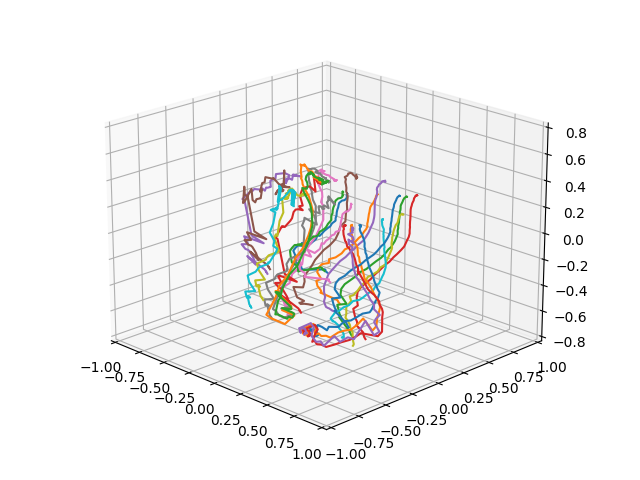

data[0][0] = [[ 7.936238e-02  7.106177e-02  3.517272e+00]
 [ 1.010784e-01  3.504309e-01  3.443917e+00]
 [ 1.220797e-01  6.236944e-01  3.359351e+00]
 [ 1.033019e-01  7.517874e-01  3.331576e+00]
 [-2.466539e-02  5.546879e-01  3.465793e+00]
 [-5.944300e-02  3.067423e-01  3.545484e+00]
 [-7.170331e-02  9.833782e-02  3.578169e+00]
 [-7.432593e-02  3.818655e-02  3.575278e+00]
 [ 2.227052e-01  4.816180e-01  3.282249e+00]
 [ 2.556368e-01  2.432226e-01  3.316105e+00]
 [ 2.386806e-01  2.938406e-02  3.325991e+00]
 [ 2.129544e-01 -1.643107e-02  3.324027e+00]
 [ 2.856424e-02  8.090025e-02  3.514764e+00]
 [ 7.381444e-02 -1.723739e-01  3.652483e+00]
 [ 1.213322e-01 -4.663082e-01  3.805513e+00]
 [ 7.097869e-02 -5.142339e-01  3.721053e+00]
 [ 1.285854e-01  6.021976e-02  3.450855e+00]
 [ 2.050605e-01 -2.300286e-01  3.583552e+00]
 [ 2.468811e-01 -5.076904e-01  3.701730e+00]
 [ 1.953782e-01 -5.551464e-01  3.617387e+00]
 [ 1.169734e-01  5.562869e-01  3.382633e+00]
 [-7.215259e-02 -1.969323e-02  3.590064e+0

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import ffmpeg

# Fixing random state for reproducibility
np.random.seed(19680801)


def Gen_RandLine(length, dims=2):
    """
    Create a line using a random walk algorithm

    length is the number of points for the line.
    dims is the number of dimensions the line has.
    """
    lineData = np.empty((dims, length))
    lineData[:, 0] = np.random.rand(dims)
    for index in range(1, length):
        # scaling the random numbers by 0.1 so
        # movement is small compared to position.
        # subtraction by 0.5 is to change the range to [-0.5, 0.5]
        # to allow a line to move backwards.
        step = ((np.random.rand(dims) - 0.5) * 0.1)
        lineData[:, index] = lineData[:, index - 1] + step

    return lineData


def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)

# Fifty lines of random 3-D lines
data_prepro = sk.visual_skeleton()    # has shape (84,25,3)
# print(data_prepro[0,:,:])
# data_bis = [Gen_RandLine(30, 3) for index in range(10)]
# print(np.asarray(data).shape)   # shape (#lines,3,#frames)
data = np.zeros((25,3,84))
for i,image in enumerate(data_prepro):
    for l,line in enumerate(image):
        for c,coord in enumerate(line):
            data[l,c,i] = coord
# data = np.reshape(data_prepro,(25,3,84))

# print(data.shape)
# print(data[:,:,0])

# Creating fifty line objects.
# NOTE: Can't pass empty arrays into 3d version of plot()
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

# Setting the axes properties
ax.view_init(elev=20, azim=-45)
ax.set_xlim3d([-1, 1])
ax.set_ylim3d([-1, 1])
ax.set_zlim3d([-0.8, 0.8])
        
# ax.set_xlim3d([0.0, 1.0])
# ax.set_xlabel('X')

# ax.set_ylim3d([0.0, 1.0])
# ax.set_ylabel('Y')

# ax.set_zlim3d([0.0, 1.0])
# ax.set_zlabel('Z')

ax.set_title('3D Test')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, 84, fargs=(data, lines),
                                   interval=50, blit=False)

# plt.ioff()
# ax.axis('off')
# plt.show()
writergif = animation.PillowWriter(fps=30)
line_ani.save('animation.gif', writer=writergif)